In [18]:
import torch
import numpy as np
import numpy
from torch.nn.parameter import Parameter
import torch.optim as optim
import pickle
from sklearn.metrics.pairwise import cosine_similarity


import inspect

def method_arg_type_check(method_obj, exclude = []):
    """
    Takes the method object of a given function (e.g. RNNJANSEN) and checks that the passed arguments abide by their
    expected data types.  If there is a discrepency, raises a ValueError.

    Optional argument: exclude
        List of strings containing argument names to exclude from the check (e.g. ['step_size', 'params']).
        'self' is excluded automatically.
    """
    #This function is based on code generated by ChatGPT

    exclude.append('self')

    args_signature = inspect.signature(method_obj)
    expected_types = {param.name: param.annotation for param in args_signature.parameters.values() if param.name not in exclude} # Extract expected parameter types from the signature

    for arg_name, arg_type in expected_types.items(): # Iterate through each passed arguments' label and data type
        if arg_name in locals(): # Skip 'self' argument and check if argument is present
            if not isinstance(locals()[arg_name], arg_type): # Check if the passed arg's data type does not match its expected type
                passed_arg_type = type(locals()[arg_name]).__name__ # Passed data type
                expected_arg_type = arg_type.__name__ # Expected data type
                raise ValueError(f"{arg_name} should be of type {expected_arg_type}, but got type {passed_arg_type} instead.") # Halt if discrepancy


class par:
    '''
    Features of this class:
     - This class contains a global parameter value or array of values (one per node)
     - It can also contain associated priors (mean and variance)
     - It also has attributes for whether the parameter and/or priors should be fit during training
     - It has a method to return the parameter as numpy value
     - It has a method to set a random val using based on priors
     - It has functionality to represent val as log(val) so that during training val will be constrained to be positive

    Attributes
    ------------
    val : Tensor
        The parameter value (or an array of node specific parameter values)
    prior_mean : Tensor
        Prior mean of the data value
    prior_var : Tensor
        Prior variance of the value
    has_prior : Bool
        Whether the user provided a prior mean and variance
    fit_par: Bool
        Whether the parameter value should be set to as a PyTorch Parameter
    fit_hyper : Bool
        Whether the parameter prior mean and prior variance should be set as a PyTorch Parameter
    asLog : Bool
        Whether the log of the parameter value will be stored instead of the parameter itself (will prevent parameter from being negative).
    isPlastic : Bool
        Not yet implemented
    '''

    def __init__(self, val, prior_mean = None, prior_var = None, fit_par = False, fit_hyper = False, asLog = False, isPlastic = False, device = torch.device('cpu')):
        '''

        Parameters
        ----------
        val : Float (or Array)
            The parameter value (or an array of node specific parameter values)
        prior_mean : Float
            Prior mean of the data value
        prior_var : Float
            Prior variance of the value
        fit_par: Bool
            Whether the parameter value should be set to as a PyTorch Parameter
        fit_hyper : Bool
            Whether the parameter prior mean and prior variance should be set as a PyTorch Parameter
        asLog : Bool
            Whether the log of the parameter value will be stored instead of the parameter itself (will prevent parameter from being negative).
        isPlastic : Bool
            A future potential feature to be implemented
        device: torch.device
            Whether to run on CPU or GPU
        '''

        if numpy.all(prior_mean != None) & numpy.all(prior_var != None) & (asLog == False):
            self.has_prior = True
        elif numpy.all(prior_mean != None) & numpy.all(prior_var != None):
            raise ValueError("currently asLog representation can not be used with priors")
        elif numpy.all(prior_mean != None) | numpy.all(prior_var != None):
            raise ValueError("prior_mean and prior_var must either be both None or both set")
        else:
            self.has_prior = False
            prior_mean = 0
            prior_var = 0

        self.val = torch.tensor(val, dtype=torch.float32).to(device)
        self.asLog = asLog # Store log(val) instead of val directly, so that val itself will always stay positive during training
        if asLog:
            self.val = torch.log(self.val) #TODO: It's not ideal that the attribute is called val when it might be log(val)

        self.prior_mean = torch.tensor(prior_mean, dtype=torch.float32).to(device)
        self.prior_var = torch.tensor(prior_var, dtype=torch.float32).to(device)
        self.fit_par = fit_par
        self.fit_hyper = fit_hyper

        self.isPlastic = isPlastic #Custom functionality, may not be compatible with other features

        self.device = device

        if fit_par:
            self.val = torch.nn.parameter.Parameter(self.val)

        if fit_hyper:
            self.prior_mean = torch.nn.parameter.Parameter(self.prior_mean)
            self.prior_var = torch.nn.parameter.Parameter(self.prior_var)

    def value(self):
        '''
        Returns
        ---------
        Tensor of Value
            The parameter value(s) as a PyTorch Tensor
        '''

        if self.asLog:
            return torch.exp(self.val)
        else:
            return self.val

    def npValue(self):
        '''
        Returns
        --------
        NumPy of Value
            The parameter value(s) as a NumPy Array
        '''

        if self.asLog:
            return numpy.exp(self.val.detach().clone().cpu().numpy())
        else:
            return self.val.detach().clone().cpu().numpy()

    def to(self, device):
        '''
        '''
        self.device = device

        if self.fit_par:
            self.val = torch.nn.Parameter(self.val.detach().clone().to(device))
        else:
            self.val = self.val.to(device)

        if self.fit_hyper:
            self.prior_mean = torch.nn.Parameter(self.prior_mean.detach().clone().to(device))
            self.prior_var = torch.nn.Parameter(self.prior_var.detach().clone().to(device))
        else:
            self.prior_mean = self.prior_mean.to(device)
            self.prior_var = self.prior_var.to(device)


    def randSet(self):
        '''
        This method sets the initial value using the mean and variance of the priors.
        '''

        if self.has_prior:
            self.var = self.prior_mean.detach() + self.prior_var.detach() * torch.randn(1)
            if self.fit_par:
                self.val = torch.nn.parameter.Parameter(self.val)
        else:
            raise ValueError("must have priors provided at par object initialization to use this method")

    # The below is so that the parameter object can be used in equations.
    # Additional operations may need to be added.

    def __pos__(self):
        if self.asLog:
            return torch.exp(self.val)
        else:
            return self.val

    def __neg__(self):
        if self.asLog:
            return -torch.exp(self.val)
        else:
            return -self.val

    def __add__(self, num):
        if self.asLog:
            return torch.exp(self.val) + num
        else:
            return self.val + num

    def __radd__(self, num):
        if self.asLog:
            return num + torch.exp(self.val)
        else:
            return num + self.val

    def __sub__(self, num):
        if self.asLog:
            return torch.exp(self.val) - num
        else:
            return self.val - num

    def __rsub__(self, num):
        if self.asLog:
            return num - torch.exp(self.val)
        else:
            return num - self.val

    def __mul__(self, num):
        if self.asLog:
            return torch.exp(self.val) * num
        else:
            return self.val * num

    def __rmul__(self, num):
        if self.asLog:
            return num * torch.exp(self.val)
        else:
            return num * self.val

    def __truediv__(self, num):
        if self.asLog:
            return torch.exp(self.val) / num
        else:
            return self.val / num

    def __rtruediv__(self, num):
        if self.asLog:
            return num / torch.exp(self.val)
        else:
            return num / self.val


class Recording():
    '''
    This class is responsible for holding timeseries of empirical and simulated data. It is:
        - Part of the input and output of Model_fitting and Model_simulation[future].
        - It is the format expected by the visualization function of whobpyt.

    However, the Recording class is not used within and across the NMM and Modals, as a simpler dictionary of tensors is used in those contexts.

    Numerical simulation internals don't necessarily use this data structure, as calculations may be more efficient as the transpose: ts_length x num_regions.


    Attributes
    -------------
    data : Numpy Array or Tensor of dimensions num_regions x ts_length
        The time series data, either empirical or simulated
    step_size : Float
        The step size of the time points in the data class
    modality : String
        The name of the modality of the time series
    numNodes : Int
        The number of nodes it time series.
    length : Int
        The number of time points in the time series.


    '''

    def __init__(self, data, step_size, modality = ""):
        '''

        Parameters
        -----------

        data : Numpy Array or Tensor of dimensions num_regions x ts_length
            The time series data, either empirical or simulated
        step_size : Float
            The step size of the time points in the data class
        modality : String
            The name of the modality of the time series

        '''


        if not(torch.is_tensor(data)):
            data = torch.tensor(data) # Store as Tensor

        self.data = data
        self.step_size = step_size
        self.modality = modality
        self.numNodes = self.data.shape[0]
        self.length = self.data.shape[1]

    def pyTS(self):
        '''
        Returns
        --------
        Tensor of num_regions x ts_length

        '''

        return self.data

    def npTS(self):
        '''
        Returns
        ---------
        Numpy Array of num_regions x ts_length

        '''

        return self.data.cpu().numpy()

    def npNodeByTime(self):
        '''
        Returns
        ---------
        Numpy Array of num_regions x ts_length

        '''

        return self.data.cpu().numpy()

    def npTimeByNodes(self):
        '''
        Returns
        ---------
        Numpy Array of ts_length x num_regions

        '''

        return self.data.cpu().numpy().T

    def length(self):
        '''
        Returns
        ---------
        The time series length

        '''

        return self.length

    def npResample(self):
        '''
        This outputs resampled data used for figures (TODO: Not yet implemented)

        '''

        pass

    def windowedTensor(self, TPperWindow):
        '''
        This method is called by the Model_fitting Class during training to reshape the data into windowed segments (adds another dimension).

        Parameters
        -----------
        TPperWindow : Int
            The number of time points in the window that will be back propagated

        Returns
        ---------
        Tensor: num_windows x num_regions x window_length
            The time series data in a windowed format
        '''

        node_size = self.data.shape[0]
        length_ts = self.data.shape[1]
        num_windows = int(length_ts / TPperWindow)
        data_out = np.zeros((num_windows, node_size, TPperWindow))

        for i_win in range(num_windows):
            data_out[i_win, :, :] = self.data[:, i_win * TPperWindow:(i_win + 1) * TPperWindow]

        return data_out


class AbstractNMM(torch.nn.Module):
    # This is the abstract class for the models (typically neural mass models) that are being trained.
    # The neuroimaging modality might be integrated into the model as well.

    def __init__(self):
        super(AbstractNMM, self).__init__() # May not want to enherit from torch.nn.Module in the future

        self.state_names = ["None"] # The names of the state variables of the model
        self.output_names = ["None"] # The variable to be used as output from the NMM, for purposes such as the input to an objective function
        self.track_params = [] # Which NMM Parameters to track over training

        self.use_fit_gains = False # Whether to fit the Connectivity Matrix
        self.use_fit_lfm = False # Whether to fit the Lead Field Matrix

    def info(self):
        # Information about the model, which may be used by other classes to know which variables to use.

        return {"state_names": self.state_names,
                "output_names": self.output_names,
                "track_params": self.track_params}

    def setModelParameters(self):
        # Setting the parameters that will be optimized as either model parameters or 2ndLevel/hyper
        # parameters (for various optional features).
        # This should be called in the __init__() function implementation for convenience if possible.
        pass

    def createIC(self, ver):
        # Create the initial conditions for the model state variables.
        pass

    def createDelayIC(self, ver):
        # Creates a time series of state variables to represent their past values as needed when delays are used.

        return torch.tensor(1.0) #Dummy variable if delays are not used

    def forward(self, external, hx, hE):
        # Run the mode simulation.
        # Returns a dictionary with values of state variables during the simulation.
        pass


class AbstractParams:
    # This class stores the parameters used by a model. The parameters may be for the Neural Mass Model and/or Neuroimaging Modality.
    # It should be useable by both the pytorch model for training and a numpy model for parameter verification.

    def __init__(self, **kwargs):
        # Define the parameters using the par data structure
        pass

    def getFittedNames(self):
        # Returns a named list of paramters that are being fitted
        # Assumes the par datastructure is being used for parameters

        fp = []
        vars_names = [a for a in dir(self) if not a.startswith('__')]
        for var_name in vars_names:
            var = getattr(model.param, var_name)
            if (type(var) == whobpyt.datatypes.parameter.par):
                if (var.fit_par == True):
                    fp.append(var_name)
                if (var.fit_hyper == True):
                    fp.append(var_name + "_m")
                    fp.append(var_name + "_v_inv")
        return fp

    def to(self, device):
        # Moves all parameters between CPU and GPU

        vars_names = [a for a in dir(self) if not a.startswith('__')]
        for var_name in vars_names:
            var = getattr(self, var_name)
            if (type(var) == par):
                var.to(device)

class AbstractLoss:
    # This is the abstract class for objective function components, or for a custom objective function with multiple components.

    def __init__(self, simKey = None, device = torch.device('cpu')):

        self.simKey = simKey #This is a string key to extract from the dictionary of simulation outputs the time series used by the objective function
        device = device

    def loss(self, simData, empData):
        # Calculates a loss to be backpropagated through
        # If the objective function needs additional info, it should be defined at initialization so that the parameter fitting paradigms don't need to change

        # simData: is a dictionary of simulated state variable/neuroimaging modality time series. Typically accessed as simData[self.simKey].
        # empData: is the target either as a time series or a calculated phenomena metric

        pass

class TrainingStats:
    '''
    This class is responsible for recording stats during training (it replaces OutputNM) including:
        - The training and validation losses over time
        - The change in model parameters over time
        - changing hyper parameters over time like learing rates TODO

    These are things typically recorded on a per window/epoch basis

    Attributes
    ------------
    model_info : Dict
        Information about model being tracked during training.
    track_params : List
        List of parameter names being tracked during training.
    loss : List
        A list of loss values over training.
    connectivity : List
        A list of connectivity values over training.
    leadfield : List
        A list of leadfield matrices over training.
    fit_params : Dict
        A dictionary of lists where the key is the parameter name and the value is the list of parameter values over training.

    '''

    def __init__(self, model):
        '''

        Parameters
        -----------
        model : AbstractNMM
            A model for which stats will be recorded during training.

        '''

        model_info = model.info()
        self.track_params = model.track_params

        self.loss = []

        self.connectivity = []
        self.leadfield = []

        self.fit_params = {}

    def save(self, filename):
        '''
        Parameters
        ------------
        filename : String
            The filename to use to save the TrainingStats as a pickle object.

        '''

        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def reset(self):
        '''
        Resets the attributes of the model to a pre-training state.

        '''

        self.loss = []

        self.network_con = []
        self.leadfield = []

        self.fit_params = {}

    def appendLoss(self, newValue):
        """
        Append Trainig Loss

        Parameters
        -----------
        newValue : Float
            The loss value of objective function being tracked.

        """
        self.loss.append(newValue)

    def appendSC(self, newValue):
        """
        Append Network Connections

        Parameters
        -----------
        newValue : Array
            Current state of the structural connectivity being tracked.

        """
        self.connectivity.append(newValue)

    def appendLF(self, newValue):
        """
        Append Lead Field Loss

        Parameters
        -----------
        newValue : Array
            Current state of a lead field matrix being tracked.

        """
        self.leadfield.append(newValue)

    def appendParam(self, newValues):
        """
        Append Fit Parameters

        Parameters
        ----------
        newValues : Dict
            Dictionary with current states of each model parameter being tracked.

        """
        if (self.fit_params == {}):
            for name in newValues.keys():
                self.fit_params[name] = [newValues[name]]
        else:
            for name in newValues.keys():
                self.fit_params[name].append(newValues[name])


class AbstractFitting():
    # AbstractFitting is a template class for different parameter optimization or machine learning paradigms to inherit from.

    def __init__(self, model: AbstractNMM, cost: AbstractLoss, device = torch.device('cpu')):
        # Initializing the class

        self.model = model
        self.cost = cost
        self.device = device

        self.trainingStats = TrainingStats(self.model)
        self.lastRec = None # Saves the last simulation during training


    def save(self, filename):
        # Saving the entire class
        with open(filename, 'wb') as f:
            pickle.dump(self, f)


    def train():
        # This function is for training of a model.
        pass


    def evaluate():
        # The function is intended to calculate statistics as they are calculated during training, but not updating model parameters.
        pass


    def simulate():
        # This function is intended for running some fixed duration of simulation.
        pass




class ParamsJR(AbstractParams):
    """
    A class for setting the parameters of a neural mass model for EEG data fitting.

    Attributes:
        A (par): The amplitude of the EPSP (excitatory post synaptic potential).
        a (par): A metric of the rate constant for the EPSP.
        B (par): The amplitude of the IPSP (inhibitory post synaptic potential).
        b (par): A metric of the rate constant for the IPSP.
        g (par): The gain of ???.
        c1 (par): The connectivity parameter from the pyramidal to excitatory interneurons.
        c2 (par): The connectivity parameter from the excitatory interneurons to the pyramidal cells.
        c3 (par): The connectivity parameter from the pyramidal to inhibitory interneurons.
        c4 (par): The connectivity parameter from the inhibitory interneurons to the pyramidal cells.
        std_in (par): The standard deviation of the input noise.
        vmax (par): The maximum value of the sigmoid function.
        v0 (par): The midpoint of the sigmoid function.
        r (par): The slope of the sigmoid function.
        y0 (par): ???.
        mu (par): The mean of the input.
        k (par): ???.
        cy0 (par): ???.
        ki (par): ???.
    """
    def __init__(self, **kwargs):
        """
        Initializes the ParamsJR object.

        Args:
            **kwargs: Keyword arguments for the model parameters.

        Returns:
            None
        """
        param = {
            "A ": par(3.25),
            "a": par(100),
            "B": par(22),
            "b": par(50),
            "g": par(1000),

            "c1": par(135),
            "c2": par(135 * 0.8),
            "c3 ": par(135 * 0.25),
            "c4": par(135 * 0.25),

            "std_in": par(100),
            "vmax": par(5),
            "v0": par(6),
            "r": par(0.56),
            "y0": par(2),

            "mu": par(.5),
            "k": par(5),
            "cy0": par(5),
            "ki": par(1)
        }

        for var in param:
            setattr(self, var, param[var])

        for var in kwargs:
            setattr(self, var, kwargs[var])


class CostsTS(AbstractLoss):
    def __init__(self, simKey):
        super(CostsTS, self).__init__(simKey)
        self.simKey = simKey

    def loss(self, simData: dict, empData: torch.Tensor):
        """
        Calculate the Pearson Correlation between the simFC and empFC.
        From there, compute the probability and negative log-likelihood.

        Parameters
        ----------
        simData: dict of tensor with node_size X datapoint
            simulated EEG
        empData: tensor with node_size X datapoint
            empirical EEG
        """
        method_arg_type_check(self.loss) # Check that the passed arguments (excluding self) abide by their expected data types
        sim = simData[self.simKey]
        emp = empData

        losses = torch.sqrt(torch.mean((sim - emp) ** 2))  #
        return losses


class RNNJANSEN(AbstractNMM):
    """
    A module for forward model (JansenRit) to simulate EEG signals

    Attibutes
    ---------
    state_size : int
        Number of states in the JansenRit model

    output_size : int
        Number of EEG channels.

    node_size: int
        Number of ROIs

    hidden_size: int
        Number of step_size for each sampling step

    step_size: float
        Integration step for forward model

    tr : float # TODO: CHANGE THE NAME TO sampling_rate
        Sampling rate of the simulated EEG signals

    TRs_per_window: int # TODO: CHANGE THE NAME
        Number of EEG signals to simulate

    sc: ndarray (node_size x node_size) of floats
        Structural connectivity

    lm: ndarray of floats
        Leadfield matrix from source space to EEG space

    dist: ndarray of floats
        Distance matrix

    use_fit_gains: bool
        Flag for fitting gains. 1: fit, 0: not fit

    use_fit_lfm: bool
        Flag for fitting the leadfield matrix. 1: fit, 0: not fit

    # FIGURE OUT: g, c1, c2, c3, c4: tensor with gradient on
    #     model parameters to be fit

    std_in: tensor with gradient on
        Standard deviation for input noise

    params: ParamsJR
        Model parameters object.


    Methods
    -------
    createIC(self, ver):
        Creates the initial conditions for the model.

    createDelayIC(self, ver):
        Creates the initial conditions for the delays.

    setModelParameters(self):
        Sets the parameters of the model.

    forward(input, noise_out, hx)
        Forward pass for generating a number of EEG signals with current model parameters

    """

    def __init__(self, node_size: int,
                 TRs_per_window: int, step_size: float, output_size: int, tr: float, sc: np.ndarray, lm: np.ndarray, dist: np.ndarray,
                 use_fit_gains: bool, use_fit_lfm: bool, params: ParamsJR) -> None:
        """
        Parameters
        ----------
        node_size: int
            Number of ROIs
        TRs_per_window: int # TODO: CHANGE THE NAME
            Number of EEG signals to simulate
        step_size: float
            Integration step for forward model
        output_size : int
            Number of EEG channels.
        tr : float # TODO: CHANGE THE NAME TO sampling_rate
            Sampling rate of the simulated EEG signals
        sc: ndarray node_size x node_size float array
            Structural connectivity
        lm: ndarray float array
            Leadfield matrix from source space to EEG space
        dist: ndarray float array
            Distance matrix
        use_fit_gains: bool
            Flag for fitting gains. 1: fit, 0: not fit
        use_fit_lfm: bool
            Flag for fitting the leadfield matrix. 1: fit, 0: not fit
        params: ParamsJR
            Model parameters object.
        """
        method_arg_type_check(self.__init__) # Check that the passed arguments (excluding self) abide by their expected data types

        super(RNNJANSEN, self).__init__()
        self.state_names = ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']
        self.output_names = ["eeg"]
        self.track_params = [] #Is populated during setModelParameters()

        self.model_name = "JR"
        self.state_size = 6  # 6 states JR model
        self.tr = tr  # tr ms (integration step 0.1 ms)
        self.step_size = torch.tensor(step_size, dtype=torch.float32)  # integration step 0.1 ms
        self.steps_per_TR = int(tr / step_size)
        self.TRs_per_window = TRs_per_window  # size of the batch used at each step
        self.node_size = node_size  # num of ROI
        self.output_size = output_size  # num of EEG channels
        self.sc = sc  # matrix node_size x node_size structure connectivity
        self.dist = torch.tensor(dist, dtype=torch.float32)
        self.lm = lm
        self.use_fit_gains = use_fit_gains  # flag for fitting gains
        self.use_fit_lfm = use_fit_lfm
        self.params = params
        self.output_size = lm.shape[0]  # number of EEG channels

        self.setModelParameters()

    def info(self):
        # TODO: Make sure this method is useful
        """
        Returns a dictionary with the names of the states and the output.

        Returns
        -------
        Dict[str, List[str]]
        """

        return {"state_names": ['E', 'Ev', 'I', 'Iv', 'P', 'Pv'], "output_names": ["eeg"]}

    def createIC(self, ver):
        """
        Creates the initial conditions for the model.

        Parameters
        ----------
        ver : int # TODO: ADD MORE DESCRIPTION
            Initial condition version. (in the JR model, the version is not used. It is just for consistency with other models)

        Returns
        -------
        torch.Tensor
            Tensor of shape (node_size, state_size) with random values between `state_lb` and `state_ub`.
        """

        state_lb = -0.5
        state_ub = 0.5

        return torch.tensor(np.random.uniform(state_lb, state_ub, (self.node_size, self.state_size)),
                             dtype=torch.float32)

    def createDelayIC(self, ver):
        """
        Creates the initial conditions for the delays.

        Parameters
        ----------
        ver : int
            Initial condition version. (in the JR model, the version is not used. It is just for consistency with other models)

        Returns
        -------
        torch.Tensor
            Tensor of shape (node_size, delays_max) with random values between `state_lb` and `state_ub`.
        """

        delays_max = 500
        state_ub = 0.5
        state_lb = -0.5

        return torch.tensor(np.random.uniform(state_lb, state_ub, (self.node_size, delays_max)), dtype=torch.float32)

    def setModelParameters(self):
        """
        Sets the parameters of the model.
        """

        param_reg = []
        param_hyper = []

        # Set w_bb, w_ff, and w_ll as attributes as type Parameter if use_fit_gains is True
        if self.use_fit_gains:
            self.w_bb = Parameter(torch.tensor(np.zeros((self.node_size, self.node_size)) + 0.05, # the backwards gains
                                                dtype=torch.float32))
            self.w_ff = Parameter(torch.tensor(np.zeros((self.node_size, self.node_size)) + 0.05, # the forward gains
                                                dtype=torch.float32))
            self.w_ll = Parameter(torch.tensor(np.zeros((self.node_size, self.node_size)) + 0.05, # the lateral gains
                                                dtype=torch.float32))
            param_reg.append(self.w_ll)
            param_reg.append(self.w_ff)
            param_reg.append(self.w_bb)
        else:
            self.w_bb = torch.tensor(np.zeros((self.node_size, self.node_size)), dtype=torch.float32)
            self.w_ff = torch.tensor(np.zeros((self.node_size, self.node_size)), dtype=torch.float32)
            self.w_ll = torch.tensor(np.zeros((self.node_size, self.node_size)), dtype=torch.float32)

        # If use_fit_lfm is True, set lm as an attribute as type Parameter (containing variance information)
        if self.use_fit_lfm:
            self.lm = Parameter(torch.tensor(self.lm, dtype=torch.float32))  # leadfield matrix from sourced data to eeg
            param_reg.append(self.lm)
        else:
            self.lm = torch.tensor(self.lm, dtype=torch.float32)

        var_names = [a for a in dir(self.params) if (type(getattr(self.params, a)) == par)]
        for var_name in var_names:
            var = getattr(self.params, var_name)
            if (var.fit_hyper):
                if var_name == 'lm':
                    size = var.prior_var.shape
                    var.val = Parameter(var.val.detach() - 1 * torch.ones((size[0], size[1]))) # TODO: This is not consistent with what user would expect giving a variance
                    param_hyper.append(var.prior_mean)
                    param_hyper.append(var.prior_var)
                elif (var != 'std_in'):
                    var.randSet() #TODO: This should be done before giving params to model class
                    param_hyper.append(var.prior_mean)
                    param_hyper.append(var.prior_var)

            if (var.fit_par):
                param_reg.append(var.val) #TODO: This should got before fit_hyper, but need to change where randomness gets added in the code first

            if (var.fit_par | var.fit_hyper):
                self.track_params.append(var_name) #NMM Parameters

            if var_name == 'lm':
                setattr(self, var_name, var.val)

        self.params_fitted = {'modelparameter': param_reg,'hyperparameter': param_hyper}


    def forward(self, external, hx, hE):
        """
        This function carries out the forward Euler integration method for the JR neural mass model,
        with time delays, connection gains, and external inputs considered. Each population (pyramidal,
        excitatory, inhibitory) in the network is modeled as a non-linear second order system. The function
        updates the state of each neural population and computes the EEG signals at each time step.

        Parameters
        ----------
        external : torch.Tensor
            Input tensor of shape (batch_size, num_ROIs) representing the input to the model.
        hx : Optional[torch.Tensor]
            Optional tensor of shape (batch_size, state_size, num_ROIs) representing the initial hidden state.
        hE : Optional[torch.Tensor]
            Optional tensor of shape (batch_size, num_ROIs, delays_max) representing the initial delays.

        Returns
        -------
        next_state : dict
            Dictionary containing the updated current state, EEG signals, and the history of
            each population's current and voltage at each time step.

        hE : torch.Tensor
            Tensor representing the updated history of the pyramidal population's current.
        """

        # Generate the ReLU module
        m = torch.nn.ReLU()

        # Define some constants
        con_1 = torch.tensor(1.0, dtype=torch.float32) # Define constant 1 tensor
        conduct_lb = 1.5  # lower bound for conduct velocity
        u_2ndsys_ub = 500  # the bound of the input for second order system
        noise_std_lb = 20  # lower bound of std of noise
        lb = 0.01  # lower bound of local gains
        k_lb = 0.5  # lower bound of coefficient of external inputs


        # Defining NMM Parameters to simplify later equations
        #TODO: Change code so that params returns actual value used without extras below
        A = 0 * con_1 + m(self.params.A.value())
        a = 1 * con_1 + m(self.params.a.value())
        B = 0 * con_1 + m(self.params.B.value())
        b = 1 * con_1 + m(self.params.b.value())
        g = (lb * con_1 + m(self.params.g.value()))
        c1 = (lb * con_1 + m(self.params.c1.value()))
        c2 = (lb * con_1 + m(self.params.c2.value()))
        c3 = (lb * con_1 + m(self.params.c3.value()))
        c4 = (lb * con_1 + m(self.params.c4.value()))
        std_in = (noise_std_lb * con_1 + m(self.params.std_in.value()))
        vmax = self.params.vmax.value()
        v0 = self.params.v0.value()
        r = self.params.r.value()
        y0 = self.params.y0.value()
        mu = (conduct_lb * con_1 + m(self.params.mu.value()))
        k = (k_lb * con_1 + m(self.params.k.value()))
        cy0 = self.params.cy0.value()
        ki = self.params.ki.value()

        g_f = (lb * con_1 + m(self.params.g_f.value()))
        g_b = (lb * con_1 + m(self.params.g_b.value()))


        next_state = {}

        M = hx[:, 0:1]  # current of pyramidal population
        E = hx[:, 1:2]  # current of excitory population
        I = hx[:, 2:3]  # current of inhibitory population

        Mv = hx[:, 3:4]  # voltage of pyramidal population
        Ev = hx[:, 4:5]  # voltage of exictory population
        Iv = hx[:, 5:6]  # voltage of inhibitory population

        dt = self.step_size

        if self.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains w_bb.
            w_b = torch.exp(self.w_bb) * torch.tensor(self.sc, dtype=torch.float32)
            w_n_b = w_b / torch.linalg.norm(w_b)
            self.sc_m_b = w_n_b
            dg_b = -torch.diag(torch.sum(w_n_b, dim=1))

            # Update the Laplacian based on the updated connection gains w_ff.
            w_f = torch.exp(self.w_ff) * torch.tensor(self.sc, dtype=torch.float32)
            w_n_f = w_f / torch.linalg.norm(w_f)
            self.sc_m_f = w_n_f
            dg_f = -torch.diag(torch.sum(w_n_f, dim=1))

            # Update the Laplacian based on the updated connection gains w_ll.
            w_l = torch.exp(self.w_ll) * torch.tensor(self.sc, dtype=torch.float32)
            w_n_l = (0.5 * (w_l + torch.transpose(w_l, 0, 1))) / torch.linalg.norm(
                0.5 * (w_l + torch.transpose(w_l, 0, 1)))
            self.sc_fitted = w_n_l
            dg_l = -torch.diag(torch.sum(w_n_l, dim=1))
        else:
            l_s = torch.tensor(np.zeros((1, 1)), dtype=torch.float32) #TODO: This is not being called anywhere
            dg_l = 0
            dg_b = 0
            dg_f = 0
            w_n_l = 0
            w_n_b = 0
            w_n_f = 0

        self.delays = (self.dist / mu).type(torch.int64)

        # Placeholder for the updated current state
        current_state = torch.zeros_like(hx)

        # Initializing lists for the history of the EEG signals, as well as each population's current and voltage.
        eeg_window = []
        E_window = []
        I_window = []
        M_window = []
        Ev_window = []
        Iv_window = []
        Mv_window = []

        # Use the forward model to get EEG signal at the i-th element in the window.
        for i_window in range(self.TRs_per_window):
            for step_i in range(self.steps_per_TR):
                Ed = torch.tensor(np.zeros((self.node_size, self.node_size)), dtype=torch.float32)  # delayed E
                hE_new = hE.clone()
                Ed = hE_new.gather(1, self.delays)
                LEd_b = torch.reshape(torch.sum(w_n_b * torch.transpose(Ed, 0, 1), 1),
                                    (self.node_size, 1))
                LEd_f = torch.reshape(torch.sum(w_n_f * torch.transpose(Ed, 0, 1), 1),
                                    (self.node_size, 1))
                LEd_l = torch.reshape(torch.sum(w_n_l * torch.transpose(Ed, 0, 1), 1),
                                    (self.node_size, 1))

                # TMS (or external) input
                u_tms = external[:, step_i:step_i + 1, i_window]
                rM = k * ki * u_tms + std_in * torch.randn(self.node_size, 1) + \
                    1 * g * (LEd_l + 1 * torch.matmul(dg_l, M)) + \
                    sigmoid(E - I, vmax, v0, r)  # firing rate for pyramidal population
                rE = std_in * torch.randn(self.node_size, 1) + \
                    1 * g_f * (LEd_f + 1 * torch.matmul(dg_f, E - I)) + \
                    c2 * sigmoid(c1 * M, vmax, v0, r)  # firing rate for excitatory population
                rI = std_in * torch.randn(self.node_size, 1) + \
                    1 * g_b * (-LEd_b - 1 * torch.matmul(dg_b, E - I)) + \
                    c4 * sigmoid(c3 * M, vmax, v0, r)  # firing rate for inhibitory population

                # Update the states with every step size.
                ddM = M + dt * Mv
                ddE = E + dt * Ev
                ddI = I + dt * Iv
                ddMv = Mv + dt * sys2nd(A, a, u_2ndsys_ub * torch.tanh(rM / u_2ndsys_ub), M, Mv)
                ddEv = Ev + dt * sys2nd(A, a, u_2ndsys_ub * torch.tanh(rE / u_2ndsys_ub), E, Ev)
                ddIv = Iv + dt * sys2nd(B, b, u_2ndsys_ub * torch.tanh(rI / u_2ndsys_ub), I, Iv)

                # Calculate the saturation for model states (for stability and gradient calculation).
                E = 1000*torch.tanh(ddE/1000)
                I = 1000*torch.tanh(ddI/1000)
                M = 1000*torch.tanh(ddM/1000)
                Ev = 1000*torch.tanh(ddEv/1000)
                Iv = 1000*torch.tanh(ddIv/1000)
                Mv = 1000*torch.tanh(ddMv/1000)

                # Update placeholders for pyramidal buffer
                hE[:, 0] = M[:, 0]

            # Capture the states at every tr in the placeholders for checking them visually.
            M_window.append(M)
            I_window.append(I)
            E_window.append(E)
            Mv_window.append(Mv)
            Iv_window.append(Iv)
            Ev_window.append(Ev)
            hE = torch.cat([M, hE[:, :-1]], dim=1)  # update placeholders for pyramidal buffer

            # Capture the states at every tr in the placeholders which is then used in the cost calculation.
            lm_t = (self.lm.T / torch.sqrt(self.lm ** 2).sum(1)).T
            self.lm_t = (lm_t - 1 / self.output_size * torch.matmul(torch.ones((1, self.output_size)), lm_t))
            temp = cy0 * torch.matmul(self.lm_t, M[:200, :]) - 1 * y0
            eeg_window.append(temp)

        # Update the current state.
        current_state = torch.cat([M, E, I, Mv, Ev, Iv], dim=1)
        next_state['current_state'] = current_state
        next_state['eeg'] = torch.cat(eeg_window, dim=1)
        next_state['E'] = torch.cat(E_window, dim=1)
        next_state['I'] = torch.cat(I_window, dim=1)
        next_state['P'] = torch.cat(M_window, dim=1)
        next_state['Ev'] = torch.cat(Ev_window, dim=1)
        next_state['Iv'] = torch.cat(Iv_window, dim=1)
        next_state['Pv'] = torch.cat(Mv_window, dim=1)

        return next_state, hE


def sigmoid(x, vmax, v0, r):
    """
    Calculates the sigmoid function for a given input.

    Args:
        x (torch.Tensor): The input tensor.
        vmax (float): The maximum value of the sigmoid function.
        v0 (float): The midpoint of the sigmoid function.
        r (float): The slope of the sigmoid function.

    Returns:
        torch.Tensor: The output tensor.
    """
    return vmax / (1 + torch.exp(r * (v0 - x)))

def sys2nd(A, a, u, x, v):
    """
    Calculates the second-order system (for each population [represented by A, a]) for a given set of inputs.

    Args:
        A (float): The amplitude of the PSP.
        a (float): Metric of the rate constant of the PSP.
        u (torch.Tensor): The input tensor.
        x (torch.Tensor): The state tensor.
        v (torch.Tensor): The delay tensor.

    Returns:
        torch.Tensor: The output tensor.
    """
    return A * a * u - 2 * a * v - a ** 2 * x




class Model_fitting(AbstractFitting):
    """
    This Model_fitting class is able to fit resting state data or evoked potential data
    for which the input training data is empty or some stimulus to one or more NMM nodes,
    and the label is an associated empirical neuroimaging recording.

    Studies which consider different kinds of input, such as if SC or some other variable
    is associated with an empirical recording, must use a different fitting class.

    Attributes
    ----------
    model: AbstractNMM
        Whole Brain Model to Simulate
    cost: AbstractLoss
        A particular objective function which the model will be optimized for.
    trainingStats: TrainingStats
        Information about objective function loss and parameter values over training windows/epochs
    lastRec: Recording
        The last simulation of fitting(), evaluation(), or simulation()
    device : torch.device
        Whether the fitting is to run on CPU or GPU
    """

    def __init__(self, model: AbstractNMM, cost: AbstractLoss, device = torch.device('cpu')):
        """
        Parameters
        ----------
        model: AbstractNMM
            Whole Brain Model to Simulate
        cost: AbstractLoss
            A particular objective function which the model will be optimized for.
        device : torch.device
            Whether the fitting is to run on CPU or GPU
        """
        method_arg_type_check(self.__init__) # Check that the passed arguments (excluding self) abide by their expected data types

        self.model = model
        self.cost = cost

        self.device = device

        self.trainingStats = TrainingStats(self.model)
        self.lastRec = None #A dictionary or Recordings of the last simulation preformed (either training or evaluation)

        #self.u = None #This is the ML "Training Input"
        #self.empTS = ts #This is the ML "Training Labels" - A list

    def save(self, filename):
        """
        Parameters
        ----------
        filename: String
            filename to use when saving object to file
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def train(self, u, empRecs: list,
              num_epochs: int, TPperWindow: int, learningrate: float = 0.05, lr_2ndLevel: float = 0.05, lr_scheduler: bool = False):
        """
        Parameters
        ----------
        u: type
           This stimulus is the ML "Training Input"
        empRec: list of Recording
            This is the ML "Training Labels"
        num_epochs: int
            the number of times to go through the entire training data set
        TPperWindow: int
            Number of Empirical Time Points per window. model.forward does one window at a time.
        learningrate: float
            rate of gradient descent
        lr_2ndLevel: float
            learning rate for priors of model parameters, and possibly others
        lr_scheduler: bool
            Whether to use the learning rate scheduler
        """
        method_arg_type_check(self.train, exclude = ['u']) # Check that the passed arguments (excluding self) abide by their expected data types

        # Define two different optimizers for each group
        modelparameter_optimizer = optim.Adam(self.model.params_fitted['modelparameter'], lr=learningrate, eps=1e-7)
        hyperparameter_optimizer = optim.Adam(self.model.params_fitted['hyperparameter'], lr=lr_2ndLevel, eps=1e-7)

        # Define the learning rate schedulers for each group of parameters

        if lr_scheduler:
            total_steps = 0
            for empRec in empRecs:
                total_steps += int(empRec.length/TPperWindow)*num_epochs

            # total_steps = self.num_windows*num_epochs
            hyperparameter_scheduler = optim.lr_scheduler.OneCycleLR(hyperparameter_optimizer,
                                                                     lr_hyper,
                                                                     total_steps,
                                                                     anneal_strategy = "cos")
            hlrs = []
            modelparameter_scheduler = optim.lr_scheduler.OneCycleLR(modelparameter_optimizer,
                                                                     learningrate,
                                                                     total_steps,
                                                                     anneal_strategy = "cos")
            mlrs = []

        # initial state
        X = self.model.createIC(ver = 0)
        # initials of history of E
        hE = self.model.createDelayIC(ver = 0)

        # define masks for getting lower triangle matrix indices
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # LOOP 1/4: Number of Training Epochs
        for i_epoch in range(num_epochs):

            # TRAINING_STATS: placeholders for the history of trainingStats
            loss_his = []  # loss placeholder to take the average for the epoch at the end of the epoch

            print("Epoch: ", i_epoch)

            # LOOP 2/4: Number of Recordings in the Training Dataset
            for empRec in empRecs:
                windowedTS = empRec.windowedTensor(TPperWindow)

                # TIME SERIES: Create placeholders for the simulated states and outputs of entire time series corresponding to one recording
                windListDict = {} # A Dictionary with a List of windowed time series
                for name in set(self.model.state_names + self.model.output_names):
                    windListDict[name] = []

                # initial the external inputs
                external = torch.tensor(
                    np.zeros([self.model.node_size, self.model.steps_per_TR, self.model.TRs_per_window]),
                    dtype=torch.float32)

                # LOOP 3/4: Number of windowed segments for the recording
                for win_idx in range(windowedTS.shape[0]):

                    # Reset the gradient to zeros after update model parameters.
                    hyperparameter_optimizer.zero_grad()
                    modelparameter_optimizer.zero_grad()

                    # if the external not empty
                    if not isinstance(u, int):
                        external = torch.tensor(
                            (u[:, :, win_idx * self.model.TRs_per_window:(win_idx + 1) * self.model.TRs_per_window]),
                            dtype=torch.float32)

                    # LOOP 4/4: The loop within the forward model (numerical solver), which is number of time points per windowed segment
                    next_window, hE_new = self.model(external, X, hE)

                    # Get the batch of empirical signal.
                    ts_window = torch.tensor(windowedTS[win_idx, :, :], dtype=torch.float32)

                    # calculating loss
                    loss = self.cost.loss(next_window, ts_window)

                    # TIME SERIES: Put the window of simulated forward model.
                    for name in set(self.model.state_names + self.model.output_names):
                        windListDict[name].append(next_window[name].detach().cpu().numpy())

                    # TRAINING_STATS: Adding Loss for every training window (corresponding to one backpropagation)
                    loss_his.append(loss.detach().cpu().numpy())

                    # Calculate gradient using backward (backpropagation) method of the loss function.
                    loss.backward(retain_graph=True)

                    # Optimize the model based on the gradient method in updating the model parameters.
                    hyperparameter_optimizer.step()
                    modelparameter_optimizer.step()

                    if lr_scheduler:
                        #appending (needed to plot learning rate)
                        hlrs.append(hyperparameter_optimizer.param_groups[0]["lr"])
                        mlrs.append(modelparameter_optimizer.param_groups[0]["lr"])

                        # schedular step
                        hyperparameter_scheduler.step()
                        modelparameter_scheduler.step()

                    # last update current state using next state...
                    # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                    X = next_window['current_state'].detach().clone() # dtype=torch.float32
                    hE = hE_new.detach().clone() #dtype=torch.float32

                ts_emp = np.concatenate(list(windowedTS),1) #TODO: Check this code
                fc = np.corrcoef(ts_emp)

                # TIME SERIES: Concatenate all windows together to get one recording
                for name in set(self.model.state_names + self.model.output_names):
                        windListDict[name] = np.concatenate(windListDict[name], axis=1)

                ts_sim = windListDict[self.model.output_names[0]]
                fc_sim = np.corrcoef(ts_sim[:, 10:])

                print('epoch: ', i_epoch,
                      'loss:', loss.detach().cpu().numpy(),
                      'Pseudo FC_cor: ', np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], #Calling this Pseudo as different windows of the time series have slighly different parameter values
                      'cos_sim: ', np.diag(cosine_similarity(ts_sim, ts_emp)).mean())

                if lr_scheduler:
                    print('Modelparam_lr: ', modelparameter_scheduler.get_last_lr()[0])
                    print('Hyperparam_lr: ', hyperparameter_scheduler.get_last_lr()[0])

            # TRAINING_STATS: Put the updated model parameters into the history placeholders at the end of every epoch.
            # Additing Mean Loss for the Epoch
            self.trainingStats.appendLoss(np.mean(loss_his))
            # NMM/Other Parameter info for the Epoch (a list where a number is recorded every window of every record)
            trackedParam = {}
            exclude_param = ['gains_con', 'lm'] #This stores SC and LF which are saved seperately
            if(self.model.track_params):
                for par_name in self.model.track_params:
                    var = getattr(self.model.params, par_name)
                    if (var.fit_par):
                        trackedParam[par_name] = var.value().detach().cpu().numpy().copy()
                    if (var.fit_hyper):
                        trackedParam[par_name + "_prior_mean"] = var.prior_mean.detach().cpu().numpy().copy()
                        trackedParam[par_name + "_prior_var"] = var.prior_var.detach().cpu().numpy().copy()
            for key, value in self.model.state_dict().items():
                if key not in exclude_param:
                    trackedParam[key] = value.detach().cpu().numpy().ravel().copy()
            self.trainingStats.appendParam(trackedParam)
            # Saving the SC and/or Lead Field State at Every Epoch
            if self.model.use_fit_gains:
                self.trainingStats.appendSC(self.model.sc_fitted.detach().cpu().numpy())
            if self.model.use_fit_lfm:
                self.trainingStats.appendLF(self.model.lm.detach().cpu().numpy())

        # Saving the last recording of training as a Model_fitting attribute
        self.lastRec = {}
        for name in set(self.model.state_names + self.model.output_names):
            self.lastRec[name] = Recording(windListDict[name], step_size = self.model.step_size) #TODO: This won't work if different variables have different step sizes

    def evaluate(self, u, empRec: list, TPperWindow: int, base_window_num: int = 0, transient_num: int = 10):
        """
        Parameters
        ----------
        u : int or Tensor
            external or stimulus
        empRec: list of Recording
            This is the ML "Training Labels"
        TPperWindow: int
            Number of Empirical Time Points per window. model.forward does one window at a time.
        base_window_num : int
            length of num_windows for resting
        transient_num : int
            The number of initial time points to exclude from some metrics
        -----------
        """
        method_arg_type_check(self.evaluate, exclude = ['u']) # Check that the passed arguments (excluding self) abide by their expected data types
        #TODO: Should be updated to take a list of u and empRec

        # initial state
        X = self.model.createIC(ver = 1)
        # initials of history of E
        hE = self.model.createDelayIC(ver = 1)

        # define mask for getting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # Create placeholders for the simulated states and outputs of entire time series corresponding to one recording
        windListDict = {} # A Dictionary with a List of windowed time series
        for name in set(self.model.state_names + self.model.output_names):
            windListDict[name] = []

        num_windows = int(empRec.length/TPperWindow)
        u_hat = np.zeros(
            (self.model.node_size,self.model.steps_per_TR,
             base_window_num*self.model.TRs_per_window + num_windows*self.model.TRs_per_window))
        u_hat[:, :, base_window_num * self.model.TRs_per_window:] = u

        # LOOP 1/2: The number of windows in a recording
        for win_idx in range(num_windows + base_window_num):

            # Get the input and output noises for the module.
            external = torch.tensor(
                (u_hat[:, :, win_idx * self.model.TRs_per_window:(win_idx + 1) * self.model.TRs_per_window]),
                dtype=torch.float32)

            # LOOP 2/2: The loop within the forward model (numerical solver), which is number of time points per windowed segment
            next_window, hE_new = self.model.forward(external, X, hE)

            # TIME SERIES: Put the window of simulated forward model.
            if win_idx > base_window_num - 1:
                for name in set(self.model.state_names + self.model.output_names):
                    windListDict[name].append(next_window[name].detach().cpu().numpy())

            # last update current state using next state...
            # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
            X = next_window['current_state'].detach().clone() # dtype=torch.float32
            hE = hE_new.detach().clone() #dtype=torch.float32

        windowedTS = empRec.windowedTensor(TPperWindow)
        ts_emp = np.concatenate(list(windowedTS),1) #TODO: Check this code
        fc = np.corrcoef(ts_emp)

        # TIME SERIES: Concatenate all windows together to get one recording
        for name in set(self.model.state_names + self.model.output_names):
            windListDict[name] = np.concatenate(windListDict[name], axis=1)

        ts_sim = windListDict[self.model.output_names[0]]
        fc_sim = np.corrcoef(ts_sim[:, transient_num:])

        print('FC_cor: ', np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1],
              'cos_sim: ', np.diag(cosine_similarity(ts_sim, ts_emp)).mean())

        # Saving the last recording of training as a Model_fitting attribute
        self.lastRec = {}
        for name in set(self.model.state_names + self.model.output_names):
            self.lastRec[name] = Recording(windListDict[name], step_size = self.model.step_size) #TODO: This won't work if different variables have different step sizes

    def simulate(self, u, numTP: int, base_window_num: int = 0, transient_num: int = 10):
        """
        Parameters
        ----------
        u : int or Tensor
            external or stimulus
        numTP : int
            The number of time points ot simulate
        base_window_num : int
            length of num_windows for resting
        transient_num : int
            The number of initial time points to exclude from some metrics
        -----------
        """
        method_arg_type_check(self.simulate, exclude = ['u']) # Check that the passed arguments (excluding self) abide by their expected data types

        num_windows = 1
        TPperWindow = numTP #TODO: May want to go back to TPperWindow so base_window_num is used correctly, but also should be made consistent with train

        # initial state
        X = self.model.createIC(ver = 1)
        # initials of history of E
        hE = self.model.createDelayIC(ver = 1)

        # define mask for getting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # Create placeholders for the simulated states and outputs of entire time series corresponding to one recording
        windListDict = {} # A Dictionary with a List of windowed time series
        for name in set(self.model.state_names + self.model.output_names):
            windListDict[name] = []

        u_hat = np.zeros(
            (self.model.node_size,self.model.steps_per_TR,
             base_window_num*self.model.TRs_per_window + num_windows*self.model.TRs_per_window))
        u_hat[:, :, base_window_num * self.model.TRs_per_window:] = u

        # LOOP 1/2: The number of windows in a recording
        for win_idx in range(num_windows + base_window_num):

            # Get the input and output noises for the module.
            external = torch.tensor(
                (u_hat[:, :, win_idx * self.model.TRs_per_window:(win_idx + 1) * self.model.TRs_per_window]),
                dtype=torch.float32)

            # LOOP 2/2: The loop within the forward model (numerical solver), which is number of time points per windowed segment
            next_window, hE_new = self.model.forward(external, X, hE)

            # TIME SERIES: Put the window of simulated forward model.
            if win_idx > base_window_num - 1:
                for name in set(self.model.state_names + self.model.output_names):
                    windListDict[name].append(next_window[name].detach().cpu().numpy())

            # last update current state using next state...
            # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
            X = next_window['current_state'].detach().clone() # dtype=torch.float32
            hE = hE_new.detach().clone() #dtype=torch.float32

        # TIME SERIES: Concatenate all windows together to get one recording
        for name in set(self.model.state_names + self.model.output_names):
            windListDict[name] = np.concatenate(windListDict[name], axis=1)

        ts_sim = windListDict[self.model.output_names[0]]
        fc_sim = np.corrcoef(ts_sim[:, transient_num:])

        # Saving the last recording of training as a Model_fitting attribute
        self.lastRec = {}
        for name in set(self.model.state_names + self.model.output_names):
            self.lastRec[name] = Recording(windListDict[name], step_size = self.model.step_size) #TODO: This won't work if different variables have different step sizes



class CostsJR(AbstractLoss):
    def __init__(self, model):
        self.mainLoss = CostsTS("eeg")
        self.simKey = "eeg"
        self.model = model

    def loss(self, simData: dict, empData: torch.Tensor):

        method_arg_type_check(self.loss) # Check that the passed arguments (excluding self) abide by their expected data types
        sim = simData
        emp = empData

        model = self.model

        # define some constants
        lb = 0.001

        w_cost = 10

        # define the relu function
        m = torch.nn.ReLU()

        exclude_param = []
        if model.use_fit_gains:
            exclude_param.append('gains_con') #TODO: Is this correct?

        if model.use_fit_lfm:
            exclude_param.append('lm') #TODO: Is this correct?

        loss_main = self.mainLoss.loss(sim, emp)

        loss_EI = 0
        loss_prior = []

        variables_p = [a for a in dir(model.params) if (type(getattr(model.params, a)) == par)]

        for var_name in variables_p:
            var = getattr(model.params, var_name)
            if var.has_prior and var_name not in ['std_in'] and \
                        var_name not in exclude_param:
                loss_prior.append(torch.sum((lb + m(var.prior_var)) * \
                                            (m(var.val) - m(var.prior_mean)) ** 2) \
                                  + torch.sum(-torch.log(lb + m(var.prior_var))))

        # total loss
        loss = 0.1 * w_cost * loss_main + 1 * sum(loss_prior) + 1 * loss_EI
        return loss


#@title whobpyt stuffs

In [19]:
%%capture

!pip install mne

#@title Install dependencies

In [20]:
# python stuff
import numpy as np
import pandas as pd
import scipy.io
import gdown
import pickle
import warnings
warnings.filterwarnings('ignore')

#neuroimaging packages
import mne

# viz stuff
import matplotlib.pyplot as plt


In [21]:
url='https://drive.google.com/drive/folders/1Qu-JyZc3-SL-Evsystg4D-DdpsGU4waB?usp=sharing'
gdown.download_folder(url, quiet=True)

file_name = './data/Subject_1_low_voltage.fif'
epoched = mne.read_epochs(file_name, verbose=False);
evoked = epoched.average()

In [22]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
labels = atlas['ROI Name']
coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms


dist = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
  for roi2 in range(coords.shape[0]):
    dist[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
    dist[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))


stim_weights = np.load('./data/stim_weights.npy')
stim_weights_thr = stim_weights.copy()
labels[np.where(stim_weights_thr>0)[0]]

sc_file =  './data/Schaefer2018_200Parcels_7Networks_count.csv'

sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
sc = np.log1p(sc) / np.linalg.norm(np.log1p(sc))


lm = np.load('./data/Subject_1_low_voltage_lf.npy')
ki0 =stim_weights_thr[:,np.newaxis]
delays = dist/conduction_velocity

In [23]:
eeg_data = evoked.data.copy()

time_start = np.where(evoked.times==-0.1)[0][0]
time_end = np.where(evoked.times==0.3)[0][0]
eeg_data = eeg_data[:,time_start:time_end]/np.abs(eeg_data).max()*4



node_size = sc.shape[0]

output_size = eeg_data.shape[0]
batch_size = 20
step_size = 0.0001
num_epoches = 120
tr = 0.001
state_size = 6
base_batch_num = 20
time_dim = 400
state_size = 6
base_batch_num = 20
hidden_size = int(tr/step_size)


# %%
# prepare data structure of the model
data_mean = Recording(eeg_data, num_epoches, batch_size)

Epoch:  0
epoch:  0 loss: -7752.684 Pseudo FC_cor:  0.5257467673375001 cos_sim:  0.004077670112695545
Epoch:  1
epoch:  1 loss: -11972.724 Pseudo FC_cor:  0.3651124043563607 cos_sim:  0.12957527099856403
Epoch:  2
epoch:  2 loss: -14658.407 Pseudo FC_cor:  0.3356110272602613 cos_sim:  0.17006946071771814
Epoch:  3
epoch:  3 loss: -16634.34 Pseudo FC_cor:  0.58285541263379 cos_sim:  0.2811918139884776
Epoch:  4
epoch:  4 loss: -18213.611 Pseudo FC_cor:  0.7917581955978531 cos_sim:  0.41671958325057656
Epoch:  5
epoch:  5 loss: -19537.322 Pseudo FC_cor:  0.8033464870437405 cos_sim:  0.49664916508900236
Epoch:  6
epoch:  6 loss: -20680.582 Pseudo FC_cor:  0.8714797954200216 cos_sim:  0.526535246357599
Epoch:  7
epoch:  7 loss: -21688.693 Pseudo FC_cor:  0.6974889430323078 cos_sim:  0.5568125287519119
Epoch:  8
epoch:  8 loss: -22591.434 Pseudo FC_cor:  0.9094352150323997 cos_sim:  0.5880560531616084
Epoch:  9
epoch:  9 loss: -23409.523 Pseudo FC_cor:  0.7437732902803804 cos_sim:  0.584861

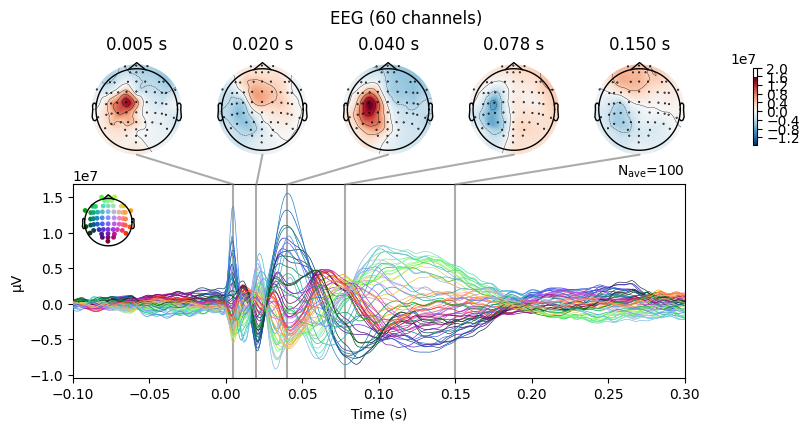

Projections have already been applied. Setting proj attribute to True.


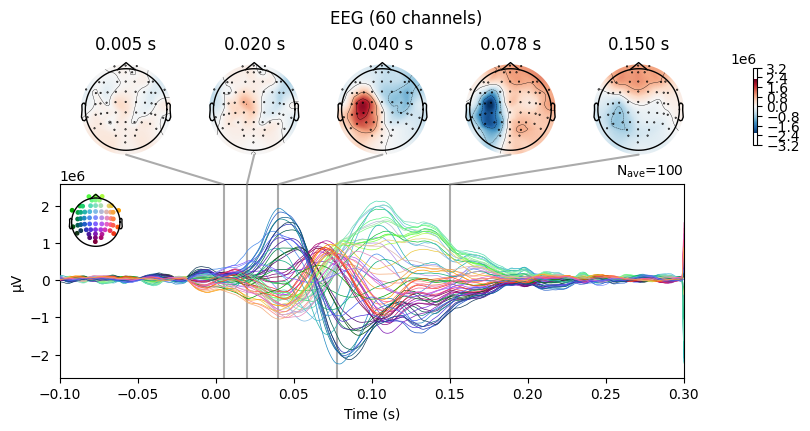

In [ ]:
lm = np.zeros((output_size,200))
lm_v = np.zeros((output_size,200))
params = ParamsJR(A = par(3.25), a= par(100,100, 2, True, True), B = par(22), b = par(50, 50, 1, True, True),
               g=par(500,500,2, True, True), g_f=par(10,10,1, True, True), g_b=par(10,10,1, True, True),
               c1 = par(135, 135, 1, True, True), c2 = par(135*0.8, 135*0.8, 1, True, True), c3 = par(135*0.25, 135*0.25, 1, True, True),
               c4 = par(135*0.25, 135*0.25, 1, True, True), std_in= par(0,0, 1, True, True), vmax= par(5), v0=par(6), r=par(0.56),
               y0=par(-2, -2, 1/4, True, True),mu = par(1., 1., 0.4, True, True), k =par(5., 5., 0.2, True, True), k0=par(0),
               cy0 = par(50, 50, 1, True, True), ki=par(ki0), lm=par(lm, lm, 1 * np.ones((output_size, node_size))+lm_v, True, True))


# %%
# call model want to fit
model = RNNJANSEN(node_size, batch_size, step_size, output_size, tr, sc, lm, dist, True, False, params)


# create objective function
ObjFun = CostsJR(model)


# %%
# call model fit
F = Model_fitting(model, ObjFun)

# %%
# model training
u = np.zeros((node_size,hidden_size,time_dim))
u[:,:,80:120]= 1000
F.train(u=u, empRecs = [data_mean], num_epochs = num_epoches, TPperWindow = batch_size)

# %%
# model test with 20 window for warmup
F.evaluate(u = u, empRec = data_mean, TPperWindow = batch_size, base_window_num = 20)





epoched = mne.read_epochs(file_name, verbose=False);
evoked = epoched.average()


ts_args = dict(xlim=[-0.1,0.3])

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.01)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.01, tmax=0.02)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.03, tmax=0.05)
ch, peak_locs4 = evoked.get_peak(ch_type='eeg', tmin=0.07, tmax=0.15)
ch, peak_locs5 = evoked.get_peak(ch_type='eeg', tmin=0.15, tmax=0.20)

times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5]
plot = evoked.plot_joint(ts_args=ts_args, times=times);




simulated_EEG_st = evoked.copy()
simulated_EEG_st.data[:,time_start:time_end] = F.lastRec['eeg'].npTS()
times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5]
simulated_joint_st = simulated_EEG_st.plot_joint(ts_args=ts_args, times=times)

In [17]:
with open('Subject_1_low_voltage_fittingresults_stim_exp.pkl', 'rb') as f:
    data = pickle.load(f)

simulated_EEG_st = evoked.copy()


time_start = np.where(evoked.times==-0.1)[0][0]
time_end = np.where(evoked.times==0.3)[0][0]


simulated_EEG_st.data[:,time_start:time_end] = data.lastRec['eeg'].npTS()
times = [peak_locs1, peak_locs2, peak_locs3, peak_locs4, peak_locs5]
simulated_joint_st = simulated_EEG_st.plot_joint(ts_args=ts_args, times=times)

FileNotFoundError: ignored

In [ ]:
corr = np.corrcoef(simulated_EEG_st._data[:, time_start:time_end].flatten(), evoked._data[:, time_start:time_end].flatten())[0,1]
print('correlation coeffient is equal to ' + str(corr))